# Importando as Bibliotecas

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import yeojohnson
from tqdm import tqdm # Import tqdm
import statsmodels.api as sm # Import statsmodels API explicitly
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller # For stationarity testing

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Tratamento dos dados

In [2]:
# --- Configuration ---
FORECAST_HORIZON = 24 # Forecast next 24 hours
TEST_SIZE_HOURS = 24*366  # Size of the test set (last 24 hours)

# --- Data Loading and Preprocessing ---
parent_path = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(parent_path, 'data', 'jena_climate_2009_2016.csv'))

df['Date Time'] = pd.to_datetime(df['Date Time'], format="%d.%m.%Y %H:%M:%S")
df.set_index('Date Time', inplace=True)
df = df.drop_duplicates()
df = df.sort_index()
df = df.resample('h').mean()

# Data Cleaning - Handling non-positive wind speed and dropna after resampling
df['wv (m/s)'] = df['wv (m/s)'].apply(lambda x: 0 if x <= 0 else x)
df['max. wv (m/s)'] = df['max. wv (m/s)'].apply(lambda x: 0 if x <= 0 else x)
df = df.dropna()

# Create Complete DatetimeIndex and Interpolate Missing Values
start_date = df.index.min()
end_date = df.index.max()
hourly_index = pd.date_range(start=start_date, end=end_date, freq='h')
df = df.reindex(hourly_index)
df = df.interpolate(method='time')

# Outlier Handling (Simple IQR method)
Q1 = df['T (degC)'].quantile(0.25)
Q3 = df['T (degC)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['T (degC)'] = np.where(df['T (degC)'] < lower_bound, lower_bound, df['T (degC)'])
df['T (degC)'] = np.where(df['T (degC)'] > upper_bound, upper_bound, df['T (degC)'])

# Feature Engineering - Time-based features
df["hour"] = df.index.hour
df["dayofyear"] = df.index.dayofyear



# Treino e teste do modelo

In [4]:

var_data = df
var_data = var_data.asfreq('h')

# --- Data Splitting ---
train_data = var_data.iloc[:-TEST_SIZE_HOURS-1]
test_data = var_data.iloc[-TEST_SIZE_HOURS-1:]


model_var = VAR(train_data)
results_var = model_var.fit(maxlags=24, ic='aic', trend='c') # Fit VAR model with AIC lag order selection
print(results_var.summary())

c:\Users\rodri.RODRIGO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1558: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Feb, 2025
Time:                     16:18:39
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -113.288
Nobs:                     61320.0    HQIC:                  -113.913
Log likelihood:       2.11521e+06    FPE:                2.54729e-50
AIC:                     -114.194    Det(Omega_mle):     2.30456e-50
--------------------------------------------------------------------
Results for equation p (mbar)
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.000069              NAN              NAN             NAN
L1.p (mbar)                 1.194020         0.020088           59.438           0.000
L1.T (degC)                -0.220

In [5]:

# --- Forecasting Function ---
def forecast_var_recursive(model, data, forecast_horizon, forecast_start):
    """
    Recursively forecasts a VAR model for a given horizon, updating time features manually.
    """
    features = data.columns
    hour_idx = features.get_loc('hour')
    day_idx = features.get_loc('dayofyear')


    forecast_rows = []
    forecast_dates = []
    original_train_obs = data.iloc[-model.k_ar*forecast_start:None if forecast_start == 1 else -model.k_ar*(forecast_start-1)].values # Use last k_ar observations from train data
    last_train_obs = original_train_obs
    current_time = data.index[-1-model.k_ar*(forecast_start-1)] # Start from the last timestamp in train data

    for _ in range(forecast_horizon):

        next_pred = model.forecast(y=last_train_obs, steps=1) # Forecast one step
        next_date = current_time + pd.Timedelta(hours=1)

        # Manual update of time features (assuming they are columns in your VAR model)
        next_pred[0][hour_idx] = next_date.hour
        next_pred[0][day_idx] = next_date.dayofyear
        

        forecast_rows.append(next_pred[0])
        forecast_dates.append(next_date)

        last_train_obs = np.vstack([last_train_obs[1:], next_pred]) # Update input for next step

        current_time = next_date
        
        
    forecast_df = pd.DataFrame(forecast_rows, columns=data.columns, index=forecast_dates)
    original_train_obs = pd.DataFrame(original_train_obs, columns=data.columns, index=forecast_dates)
    return forecast_df, original_train_obs

In [6]:
# --- Generate Forecasts for Different Periods ---
print("\n--- Generating Recursive Forecasts ---")
all_forecasts = {}
last_train_obs = {}
forecast_periods = [2,3,4] # For 3 forecast periods as in original script

for i in forecast_periods:
    forecast_df, last_train_df  = forecast_var_recursive(results_var, test_data, FORECAST_HORIZON, i) # Generate forecast
    all_forecasts[forecast_periods.index(i)] = forecast_df # Store forecast
    last_train_obs[forecast_periods.index(i)] = last_train_df # Store last training observation
    
# --- Evaluation ---
print("\n--- Evaluating Forecasts ---")
forecast_df = all_forecasts[0] # Evaluate only the first forecast for simplicity - adjust as needed
y_actual = test_data['T (degC)'].values
y_pred = forecast_df['T (degC)'].values

mae = mean_absolute_error(y_actual[-24:], y_pred)
mse = mean_squared_error(y_actual[-24:], y_pred)
r2 = r2_score(y_actual[-24:], y_pred)

print(f"\nVAR Model Evaluation (First Forecast Period):")
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


--- Generating Recursive Forecasts ---

--- Evaluating Forecasts ---

VAR Model Evaluation (First Forecast Period):
Mean Absolute Error: 1.2590962525933922
Mean Squared Error: 2.745191465696221
R² Score: 0.7449426278569695


# Teste da previsão em mais de um periodo


--- Plotting Forecasts ---


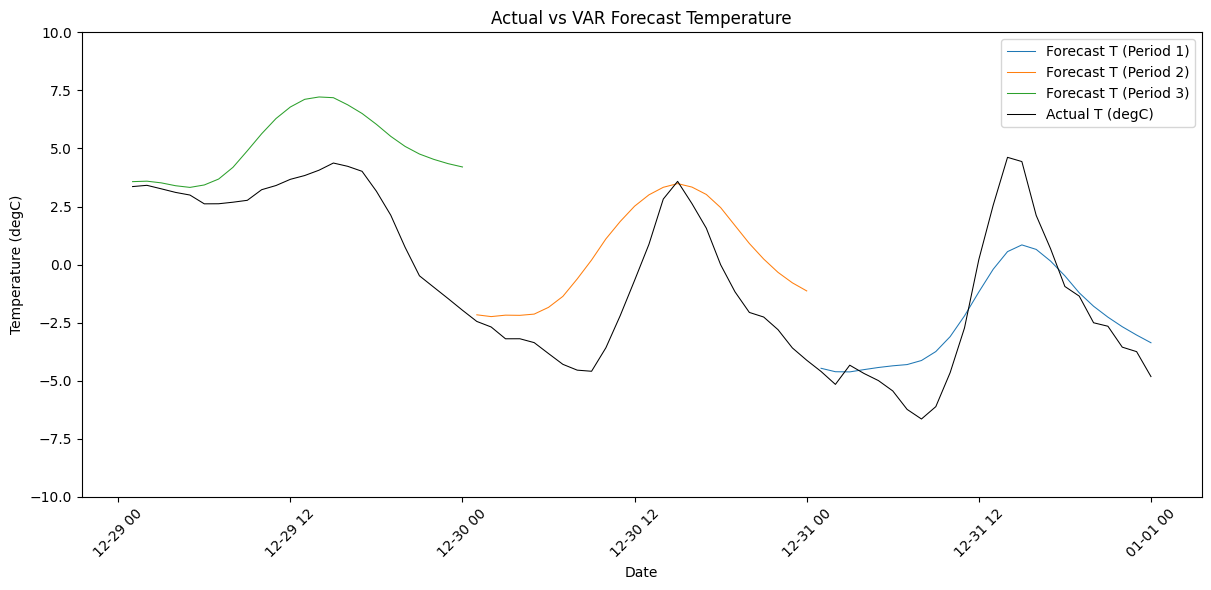

In [7]:
# --- Visualization ---
print("\n--- Plotting Forecasts ---")
plt.figure(figsize=(12, 6))

for i in forecast_periods:
    plt.plot(all_forecasts[forecast_periods.index(i)].index, all_forecasts[forecast_periods.index(i)]['T (degC)'], linewidth=0.75, label=f'Forecast T (Period {forecast_periods.index(i)+1})') # Plot forecasts

plt.plot(var_data[-72:].index, var_data['T (degC)'][-72:], linewidth=0.75, label='Actual T (degC)', color='black') # Plot actual

plt.xlabel("Date")
plt.ylabel("Temperature (degC)")
plt.title("Actual vs VAR Forecast Temperature")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()

In [8]:
all_forecasts_pred = pd.DataFrame()
forecast_periods = range(2,31*24+2) # Iterate over each row of test_data

forecast_dates_all = [] # List to store all forecast dates
forecast_values_all = [] # List to store all forecast values

for i in tqdm(forecast_periods, desc="Generating forecasts"):
    forecast_start_data = test_data.iloc[-(i + results_var.k_ar):-i] # Sliding window: k_ar rows starting from row i

    if len(forecast_start_data) < results_var.k_ar: # Handle case if not enough history at start
        continue # Skip if not enough history to start VAR forecast

    forecast_df, _  = forecast_var_recursive(results_var, forecast_start_data, FORECAST_HORIZON, 1) # Generate forecast, forecast_start=1 is now fixed and relevant

    # Extract T (degC) forecast values and dates
    forecast_temp_degC_values = forecast_df['T (degC)'].values
    forecast_temp_degC_dates = forecast_df.index

    # Extend the lists with the forecast values and dates for this iteration
    forecast_values_all.extend(forecast_temp_degC_values)
    forecast_dates_all.extend(forecast_temp_degC_dates)

# Create DataFrame from accumulated forecasts
all_forecasts_pred = pd.DataFrame({'Predicted_T (degC)': forecast_values_all}, index=forecast_dates_all)
all_forecasts_pred.index.name = 'Forecast Date' # Set index name

Generating forecasts: 100%|██████████| 744/744 [00:03<00:00, 230.72it/s]


In [9]:

# Group by the index 
grouped = all_forecasts_pred[-31*24*24:].groupby(all_forecasts_pred[-31*24*24:].index)['Predicted_T (degC)']

# Calculate summary statistics for each timestamp
summary_df = grouped.agg(
    mean='mean',
    lower=lambda x: np.percentile(x, 5),
    upper=lambda x: np.percentile(x, 95)
)
summary_df = summary_df[:-23]

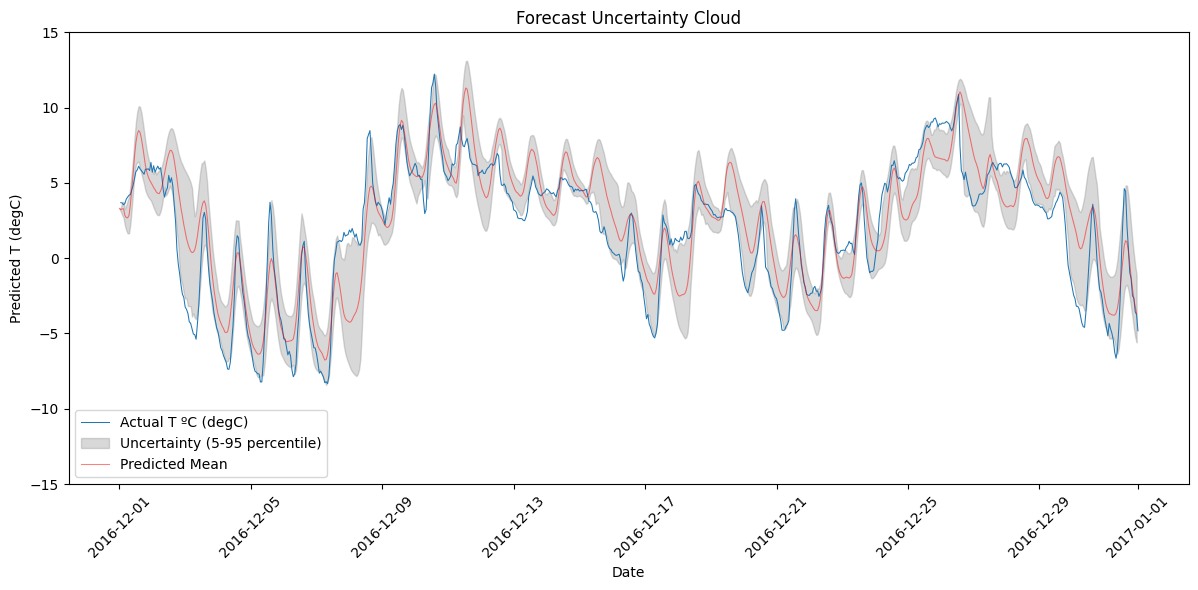

In [20]:
plt.figure(figsize=(12, 6))
# Plot the mean forecast
plt.plot(df[-24*31:].index, df['T (degC)'][-24*31:], linewidth=0.75, label='Actual T ºC (degC)') # Plot actual for the longest forecast period
# Plot uncertainty cloud using fill_between
plt.fill_between(summary_df.index, summary_df['lower'], summary_df['upper'], color='gray', alpha=0.3, label='Uncertainty (5-95 percentile)')
plt.plot(summary_df.index, summary_df['mean'], color='red', linewidth=0.75, alpha=0.5, label='Predicted Mean')
plt.xlabel("Date")
plt.ylabel("Predicted T (degC)")
plt.title("Forecast Uncertainty Cloud")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.ylim(-15, 15)
plt.show()

In [17]:
# Define the current forecast period. In your code, actuals are taken as:
actual_period = df[-24*31:]  # adjust accordingly

# Align summary_df and actual values by index
common_index = summary_df.index.intersection(actual_period.index)
y_true = actual_period.loc[common_index, 'T (degC)']
y_pred = summary_df.loc[common_index, 'mean']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)

MAE: 1.8158324066569587
MSE: 5.081658854809019
R²: 0.7221260949519958
